# Week 3. Neighbours and Clusters

This week we start with the introduction to these simple yet powerful algorithms:

* k-Nearest Neighbours (k-NN)
* k-Means Clustering (k-MC)


**Exercise** (after reading this notebook):

1. Apply k-NN to the b-jet data set.
2. Apply k-MC to the b-jet data set.

***

* Author: Vadim Rusakov
* Email:  vadim.rusakov@nbi.ku.dk
* Date:   9th of May 2021

## k-Nearest Neighbours (k-NN)

Supervised algorithm. Part of a family of other neighbour-based algorithms. Can be used for classification and regression problems. It is a non-parametric algorithm, but you can assume the type of the _distance metric_ and the _"resolution"_ of the algorithm.

Classes (or property values) for an object are assigned based on $k$-nearest neighbours.

<center><img src="images/k-neighbours.png" style="width: 300px;"/></center>

[[Image credit](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)]

* Classification scenario: classify points according to the class of their most frequent neighbour (vote on class).
* Regression scenario: some output target value $t$ is an average of the targets of $k$ neighbours.

_Assumption_: neighbouring points have similar properties and belong to the same class (often not the case, either due to noise, variable degeneracy or an unbalanced dataset).

**Algorithm**

    choose an integer k constant;
    for each object X_i in the sample (of size n):
        calculate distance d_ij between X_i and other n-1 X_j objects;
        select k smallest distances for object X_i;
        return mode (most frequent) of classes of k-NN's.

**Distance metric**

* For a set of objects with $X_1, X_2, ..., X_n$ and their labels $Y_1, Y_2, ..., Y_n$, we need to calculate distance norm between object with $X_i$ and other $n-1$ $X_j$ objects: 

$$ d_{ij} = \| X_j - X_i \|. $$

* For distance calculation it is important to transform all feature values to the range $[0,1]$, as different scale of values may place higher weight on some variables:

$$ X'=\frac{X-X_{min}}{X_{max}-X_{min}}. $$

**Distance Metric**

* Euclidean (L$_2$-norm):

$$ d_{ij} = \| X_j - X_i \| = \sqrt{(x_{j,1} - x_{i,1})^2 + (x_{j,2} - x_{i,2})^2}. $$

Other: Manhattan, Minkowski, Chebyshev, Cosine (for details see [ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric))

* $k$ - number of nearest neighbours
* $m$ - sample size
* $n$ - number of dimensions

Algorithms for computing distances between points:

* Brute-force - $\mathcal{O}(k\times m \times n)$

* KDTree

* BallTree


**"Resolution"**

* k-NN can be sensitive to the local structure of the data, if sufficiently small groups of neighbours are selected. The algorithm probes the structure scale set by the number of neighbours $k$ (constant).

* If $k=1$, the object is assigned to the class of its single neighbour.
    
* Careful! On one hand, small groups can sample the noise. On the other, too large groups can lose the ability to resolve the structure of data. It is analogous to regularisation: balance is needed not to overtrain$^1$ and not to overgeneralise. Choice of $k$ is generally data-dependent.

* If mode is used as the decision on the class voting, then use $k$ an odd number (to make sure there is a winning vote).

* Possible to use a variable $k$-number, based on the local density of objects (`sklearn` has such functionality).
    
$^1$ k-NN algorithm is not explicitly trained (no parameter optimisation is required for k-NN; it doesn't learn any internal model, simply stores the input data for future reference).

To reduce the effect of noise in the data or improve classification in an unbalanced data set, one can assign weights to distances $d_{i,j}$ for all distances between the query point $i$ and all neighbours $j$.

Typically, weights $w_i$ are taken as: 

$$ w_i=1/d_i, $$

which places higher weight on the votes (or property values) of the nearer points.

* **Strengths**:
    * Simple classification/regression (no learning is performed, only the calculation of distances).
    * Can provide multi-class outputs.
    * Non-parametric - helps with irregular, complicated decision boundaries.
    * Can be used to spot outliers. k-NN outlier - object with no close neighbours (compared to some average distance) or only neighbours of other classes.
    * k-NN can be used to probe density of objects in their feature space (based on the distance scale in a k-NN group).


* **Weaknesses**:
    * In high dimensions, distances between points are too large to differentiate between them. Therefore, dimensionality reduction step is required prior to using k-NN.
    * Predictions on large samples slow down k-NN significantly.
    * Unlike Decision Trees, doesn't tolerate the missing feature values.

<center><img src="images/faces.png" style="width: 1000px;"/></center>

[[Image credit: Scikit-Learn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multioutput_face_completion.html#sphx-glr-auto-examples-miscellaneous-plot-multioutput-face-completion-py)]

* **Use cases**:
    * Classification/regression.
    * Analysing data prior to using with other algorithms.
    * k-NN can be applied to outputs of dimensionality reduction algorithms. This and some other approaches (eg., [Large Margin Nearest Neighbour](https://en.wikipedia.org/wiki/Large_margin_nearest_neighbor)) represent a way of learning a new metric to use with the k-NN.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.metrics import accuracy_score

# funciton for scatter plots with classification probabilities
def plot_boundary_results(X, y, clf):
    # sample the whole X space with a meshgrid of probabilities
    # predicted by out trained classifier
    xx, yy = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 300),
                         np.linspace(X[:,1].min(), X[:,1].max(), 300))
    X_bkg = np.c_[xx.ravel(), yy.ravel()]
    y_bkg = clf.predict(X_bkg).reshape(xx.shape) # predict class label on a mesh
    y_pred = clf.predict(X) # predict class label for data points

    # plot the classification results
    fig, ax = plt.subplots(1, figsize=(8, 5), dpi=100)
    ax.contourf(xx, yy, y_bkg, cmap='Spectral_r', alpha=0.2, levels=1) # coloured by class
    ax.contour(xx, yy, y_bkg, cmap='Spectral_r', alpha=0.2, levels=1) # coloured by class
    ax.scatter(X[:,0][y_pred!=y], X[:,1][y_pred!=y], s=100, c='r', alpha=0.6)
    ax.scatter(X[:,0][y==0], X[:,1][y==0], s=20, c='g')
    ax.scatter(X[:,0][y==1], X[:,1][y==1], s=20, c='b')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    plt.tight_layout()

Load the "moons" data set.

In [3]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.15, random_state=42)

In [4]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=51, n_jobs=1, 
                               weights='uniform')
knn_clf.fit(X, y)
y_pred = knn_clf.predict(X)

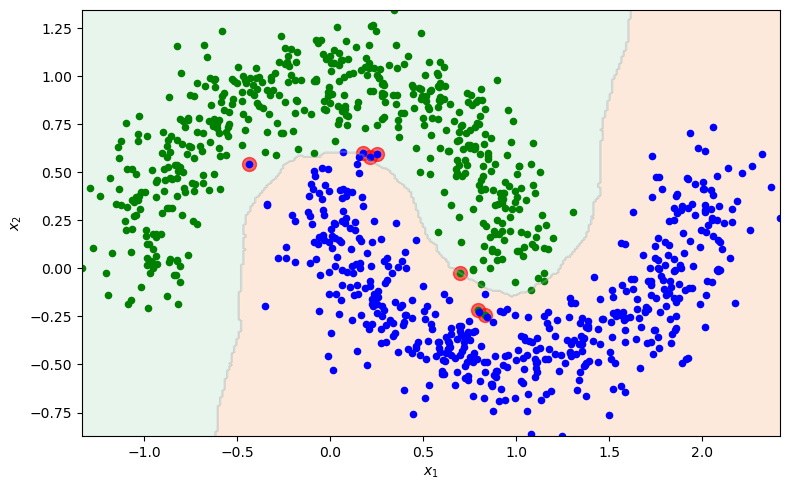

In [5]:
plot_boundary_results(X, y, knn_clf)

We can emphasize the importance of nearer neighbours by weighting them using the inverse distances. This is controlled by the `weights` parameter.

In [6]:
knn_clf = KNeighborsClassifier(n_neighbors=51, n_jobs=1, 
                               weights='distance')
knn_clf.fit(X, y)
y_pred = knn_clf.predict(X)

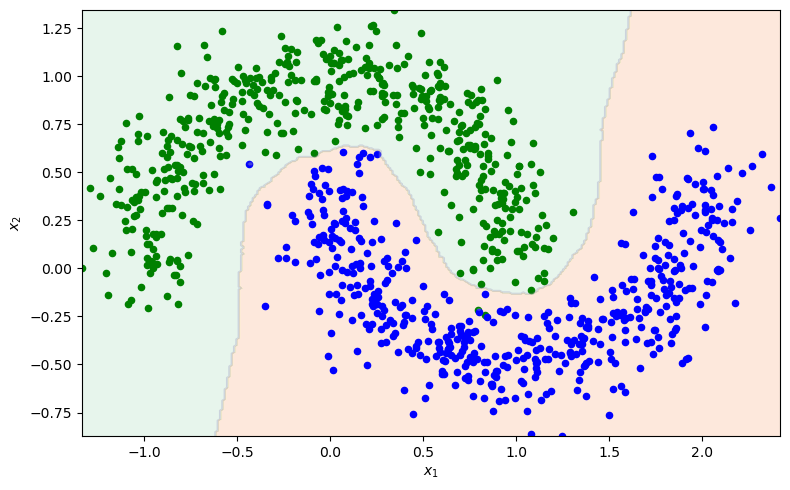

In [7]:
plot_boundary_results(X, y, knn_clf)

Now we can classify new samples based on the initial data set.

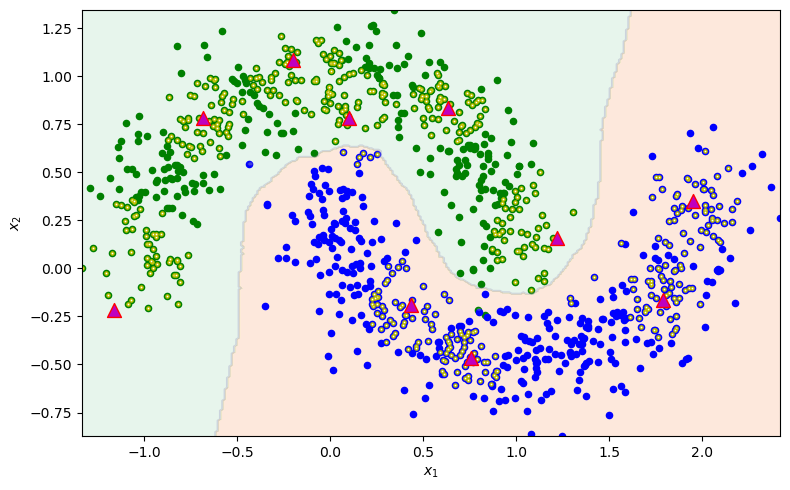

In [8]:
X_new, y_new = make_moons(n_samples=10, noise=0.15, random_state=24)

# find k-neighbours of new data points
y_dist, y_pred_idx = knn_clf.kneighbors(X_new, return_distance=True)

plot_boundary_results(X, y, knn_clf)
plt.scatter(X[y_pred_idx, 0], X[y_pred_idx, 1], s=20, c='w', 
            marker='.', edgecolor='y')
plt.scatter(X_new[:, 0], X_new[:, 1], s=100, c='m', 
            marker='^', edgecolor='r');

We may want to check how accuracy of our predictions for `X_new` changes as we vary the parameter $k$.

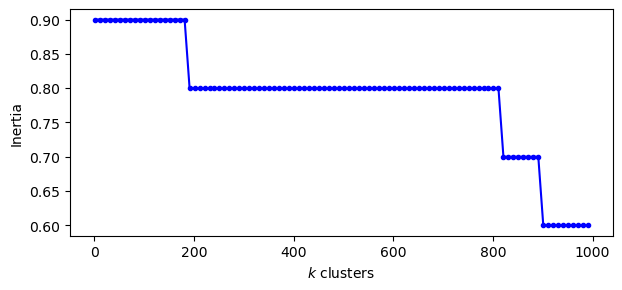

In [9]:
ks = np.arange(1, 1001, 10)
scores = []
for k in ks:
    knn_clf = KNeighborsClassifier(n_neighbors=k, n_jobs=1, 
                                   weights='uniform')
    knn_clf.fit(X, y)
    y_pred = knn_clf.predict(X_new)
    scores.append(accuracy_score(y_new, y_pred))

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Inertia'})
plt.plot(ks, scores, 'b.-')
plt.show()

**In Context with Other Classifiers**:

Suppose, you have many classifier algorithms to add to kNN and you want to make the best use of them all. 

<left><img src="images/voting-classifiers.png" style="width: 400px;"/></left>

Voting strategy (Voting Classifiers) comes at help (can use `VotingClassifier` from ScikitLearn, for eg.):

    Bag all classifiers (pipeline algorithm);
    Make predictions with all classifiers;
    Predict class with the highest vote count.

<center><img src="images/voting-classifiers2.png" style="width: 400px;"/></center>

Even if every classifier in the ensemble is only slightly better than a random guessor (weak learner), the ensemble performs better (stronger learner), if there is a sufficient number of classifiers. But requires either independently-trained classifiers (impossible, as all are trained on the same data) or classifiers with different algorithms. This ensures they make different types of errors and are as close to independent classifiers as possible.

[*Images, information credit: Geron (2019) "Hands on Machine Learning with ScikitLearn Keras and TensorFlow"*]

## k-Means Clustering (k-MC)

Unsupervised learning algorithm. Based on the assigned number of clusters $k$, k-MC splits the data set into these $k$ clusters.

**Algorithm**
    
    (1) initialize k random centroids;
    (2) compute distances between objects and centroids;
    (3) assign object labels based on the closest cluster centroid;
    (4) calculate new centroids as means of labelled objects;
    (5) repeat (2)-(4) until centroids converge.
    
<center><img src="images/k-means.png" style="width: 500px;"/></center>

*[Image credit: Geron (2019) "Hands on Machine Learning with ScikitLearn Keras and TensorFlow"]*

In `ScikitLearn` implementation the stopping criterion is the negligible change of the cluster centroid positions $\Delta \mu_j < \epsilon$, for mean cluster positions $\mu_j$ and some tolerance $\epsilon$.

Sometimes, the inertia $\mathcal{I}$ is optimised instead:

$$ \mathcal{I} = min_{\mu_j \in \mathcal{C}} {\sum_{i=0}^{m} \| X_i - \mu_j \|^2}, $$

for every cluster $\mathcal{C}$. I.e., inertia is a sum of squared distances between every instance and its respective centroid. This objective function may not work well with non-regular shapes of clusters and varying cluster sizes and densities. Still can be used as a measure of how well the placement of centroids is done (the lower the inertia the more well-defined the cluster is).

**Distance measurements**

New instances are easy to assign to the closest defined cluster centroid - _hard clustering_. _Soft clustering_ can also be used, when every instance is assigned a score.

The score can be expressed as, for example: 
* distance between the instance and the cluster centroid;
* similarity score (eg., Gaussian Radial Basis function).

**Number of clusters $k$**

NOTE: the inertia is not a good performance measure to select an optimal $k$ number, as the more clusters there exist, the closer all instances are to their cluster centres and, therefore, the lower the respective inertias.

Nevertheless, in choosing an optimal number of clusters, one might choose the $k$ value that corresponds to an "elbow" in a plot of inertia vs. $k$.

Computational complexity: $\mathcal{O}(k \times m \times n)$.

Worst case (data with no clear structure): $\mathcal{O}(m^{k+2/n})$ (exponential).
 
* $k$ - number of clusters
* $m$ - sample size
* $n$ - number of dimensions

**Strengths**:
* Guaranteed to converge on a solution;
* Fast (usually linear complexity);
* Scalable to a very large number of samples.

**Weaknesses**:
* May fall into local minimuma;
* At higher dimensions, dimensionality reduction may be needed (especially, if the inertia is used as a stopping criterion - not the case for ScikitLearn);
* Does not work well with the elongated clusters, and clusters of very different sizes.
    
<center><img src="images/k-means-local-min.png" style="width: 500px;"/></center>

*[Image credit: Geron (2019) "Hands on Machine Learning with ScikitLearn Keras and TensorFlow"]*

Typically, k-MC is restarted several times to make sure it does not end up in a local minimum at least some times. ScikitLearn implementation allows setting k-MC to restart a number of consequtive times and collecting the best solution at the end (controlled by the parameter `n_iter`), by using the inertia score.

In addition, there is a centroid initialization strategy that aims to place initial centroids at large distances from each other, which ensures the algorithm will find a better optimum. It can be specified with `init='k-means++'`.

NOTE: k-MC may may stop before converging (because of `max_iter`, for eg.). In this case, `max_iter` must be set higher to achieve convergence.

* **Use cases**:
    * Image Segmentation
    * Preprocessing

Load "Iris" dataset.

In [10]:
import seaborn as sns

iris = sns.load_dataset('iris')
X = iris.iloc[:, :-1]
y = iris['species']
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [11]:
print(f"Iris species: {pd.unique(iris['species'])}")

Iris species: ['setosa' 'versicolor' 'virginica']


In [12]:
from sklearn.cluster import KMeans

# k-means with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', 
                n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

centroids = kmeans.cluster_centers_
centroids # centroids of the identified clusters

array([[5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
       [5.006     , 3.428     , 1.462     , 0.246     ],
       [6.85      , 3.07368421, 5.74210526, 2.07105263]])

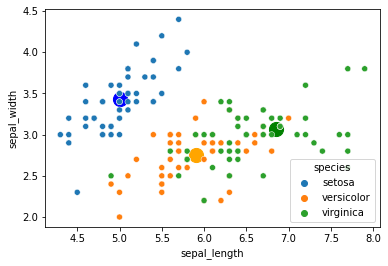

In [13]:
varA, varB, varC, varD = iris.columns[:4]
plt.scatter(centroids[0, 0], centroids[0, 1], s=200, c='orange', marker='o')
plt.scatter(centroids[1, 0], centroids[1, 1], s=200, c='b', marker='o')
plt.scatter(centroids[2, 0], centroids[2, 1], s=200, c='g', marker='o')
sns.scatterplot(x=varA, y=varB, data=iris, 
                hue='species');

classification accuracy: 0.893


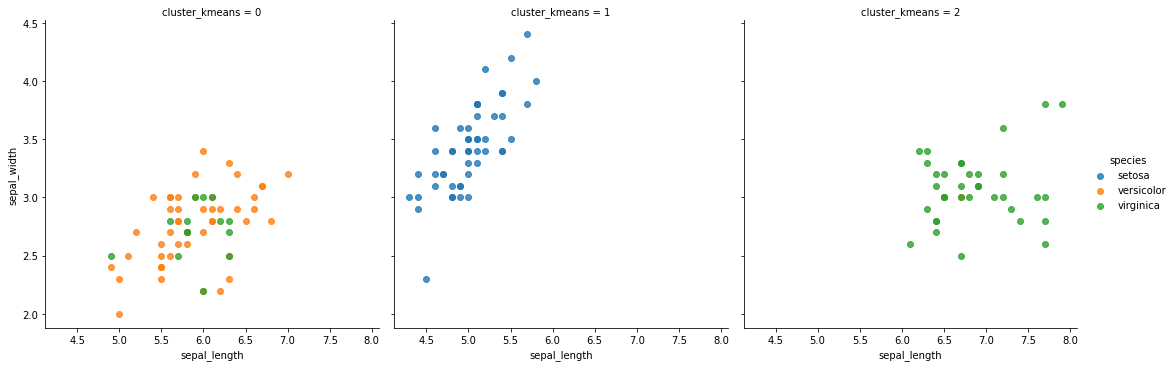

In [14]:
from sklearn.metrics import accuracy_score

iris['cluster_kmeans'] = y_pred
y_numerical = np.zeros(shape=(iris.shape[0],))
y_numerical[iris['species']=='setosa'] = 1
y_numerical[iris['species']=='virginica'] = 2
iris['species_num'] = y_numerical
sns.lmplot(x=varA, y=varB, data=iris, 
           hue='species', col='cluster_kmeans',
           fit_reg=False);
acc = accuracy_score(iris['species_num'], iris['cluster_kmeans'])
print(f"classification accuracy: {acc:.3f}")

Let us apply Principal Component Analysis to this data set and reduce its dimensionality from 4D to 2D.

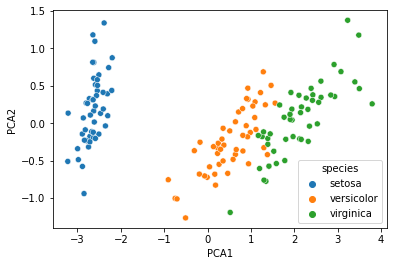

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)
iris['PCA1'] = X_2D[:, 0]
iris['PCA2'] = X_2D[:, 1]
sns.scatterplot(x='PCA1', y='PCA2', data=iris, 
                hue='species');

Now with the PCA applied, we can use kMeans again to see if better clustering can be done.

classification accuracy: 0.887


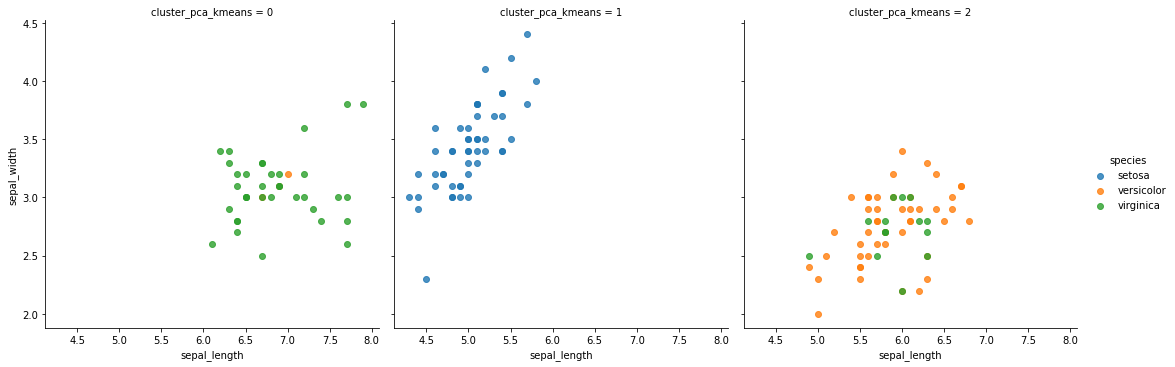

In [16]:
kmeans.fit(X_2D)
y_pred = kmeans.predict(X_2D)
iris['cluster_pca_kmeans'] = y_pred
y_numerical = np.zeros(shape=(iris.shape[0],))
y_numerical[iris['species']=='setosa'] = 1
y_numerical[iris['species']=='versicolor'] = 2
iris['species_num'] = y_numerical

sns.lmplot(x=varA, y=varB, data=iris, 
           hue='species', col='cluster_pca_kmeans',
           fit_reg=False);
acc = accuracy_score(iris['species_num'], iris['cluster_pca_kmeans'])
print(f"classification accuracy: {acc:.3f}")

Finally, let's have a look at how an "optimal" $k$ number of clusters can be selected. 

Hint: we know that "Iris" data has 3 classes of flowers.

1. First, it is possible to get a hint from how the total inertia varies with $k$, as mentioned before. Select $k$ at the curve "elbow". Here, this strategy does not work so well (it's a crude method in general). It looks like 2 clusters may be preferred by the k-Means. This is because k-Means works best with the data that is more regularly clustered (here clusters are elongated).

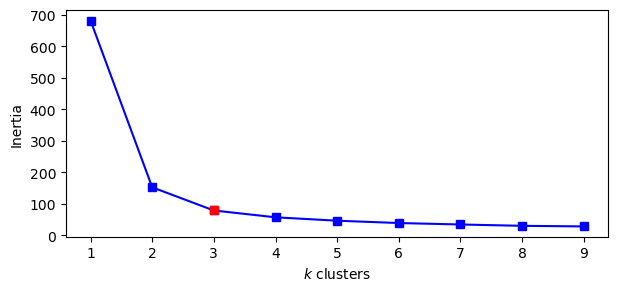

In [17]:
ks = np.arange(1, 10)
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Inertia'})
plt.plot(ks, inertias, 'bs-')
plt.plot(3, inertias[2], 'rs')
plt.show()

2. Silhouette method is more robust.

Silhouette coefficient:

$$ s = \frac{a-b}{max(a,b)}, $$

where $a$ - intra-cluster mean distance between points, $b$ - mean distance to the instances in the nearest neighbour cluster. $s \in [-1, 1]$, where +1 means the instance is well inside its cluster, 0 signifies its proximity to the boundary and -1 means the instance is in the wrong cluster.

Here again, we see that $k=2$ scores the best. We know, this is wrong due to the fact our data clusters are not best shaped for k-Means. However, we see that $k=3$ (the right answer) scores than any of $k>3$, which means we can still get a reasonble clustering with k-Means.

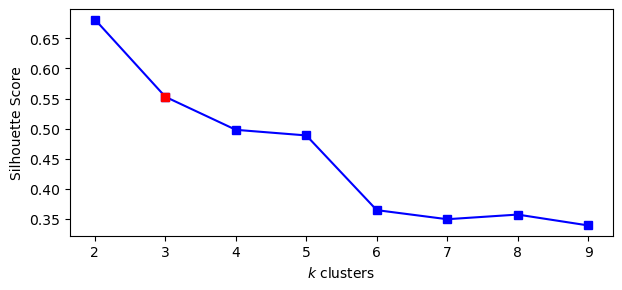

In [18]:
from sklearn.metrics import silhouette_score

ks = np.arange(2, 10)
scores = []
for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10, random_state=42)
    kmeans.fit(X)
    scores.append(silhouette_score(X, kmeans.labels_))

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Silhouette Score'})
plt.plot(ks, scores, 'bs-')
plt.plot(3, scores[1], 'rs')
plt.show()

For an overview of different clustering methods and their performance with different data sets please see the "Clutering" section on [ScikitLearn](https://scikit-learn.org/stable/modules/clustering.html).